In [1]:
import pandas as pd
import numpy as np
from itertools import repeat
from statistics import median
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
good_state_ids = ['NY','FL','CA','TX']

In [3]:
df_initial = pd.read_csv('census_data_2018_5yr.csv')

In [4]:
df = df_initial.copy()
df['geo_id'] = df['geo_id'].astype(str)
geo_map = {'36':'NY',
           '12':'FL',
           '6':'CA',
           '48':'TX'
          }
df['geo'] = df['geo_id'].apply(lambda x: geo_map[x] if x in geo_map else x)

In [5]:
multi_yr_df_initial = pd.DataFrame()
years = ['2018','2017','2016','2015','2014','2013']
for year in years:
    fn = 'census_data_%s_1yr.csv'%year
    temp = pd.read_csv(fn)
    temp['year'] = year
    multi_yr_df_initial = multi_yr_df_initial.append(temp)
    
multi_yr_df = multi_yr_df_initial.copy()
multi_yr_df['geo_id'] = multi_yr_df['geo_id'].astype(str)
multi_yr_df['geo'] = multi_yr_df['geo_id'].apply(lambda x: geo_map[x] if x in geo_map else x)

In [6]:
# all_df_initial = df_initial.append([df_initial_2017,df_initial_2016,df_initial_2015,df_initial_2014,df_initial_2013])
# all_df = all_df_initial.copy()
# all_df['do_date'] = all_df['do_date'].astype(str)
# date_year_map = {'2014-01-01':'2014',
#                  '20132017':'2014',
#                  '20122016':'2014',
#                  '20112015':'2014',
#                  '20092013':'2014',
#                 }

In [7]:
#mean by state
state_mean_df = df[['geo','income_per_capita']]
state_mean_df = state_mean_df[state_mean_df['geo'].isin(good_state_ids)]
state_mean_dict = dict(zip(state_mean_df.geo, state_mean_df.income_per_capita))

In [8]:
#mean entire country
total_mean = sum(df['total_pop'] * df['income_per_capita']) / df['total_pop'].sum()

In [9]:
keep_cols = ['geo','geo_id','total_pop']
income_cols = []
for i in df.columns:
    if 'income' in i:
        keep_cols.append(i)
        if '00' in i:
            income_cols.append(i)

In [10]:
df = df[keep_cols]

In [11]:
def get_year_incomes(data_set):
    all_incomes = []
    all_geos = []
    by_state_dict = {}

    #get a list of all incomes in data set (all_incomes)  and get that by state (by_state_dict)
    for temp_id in data_set['geo'].unique():
        state_vals = []
        temp = data_set.copy()
        temp = temp[temp['geo']==temp_id]
        for income_col in income_cols:
            temp[income_col] = temp[income_col].astype(int)
            val = income_col.split('_')[-1]
            if val == 'more':
                val = 250000
            val = int(val)

            count = temp[income_col].min()
            all_incomes.extend(repeat(val, count))
            state_vals.extend(repeat(val, count))
            all_geos.extend(repeat(temp_id,count))
        by_state_dict[temp_id] = state_vals
    return all_incomes,by_state_dict

In [12]:
all_incomes,by_state_dict = get_year_incomes(df)

In [14]:
def get_median_skew(income_list):
    #get median from list
    med_val = int(median(income_list))
    
    #get # items in list
    num_vals = len(income_list)
    
    #get median index
    median_loc = (num_vals + 1)/2
    
    #get number items below median val
    num_below_med = len([i for i in income_list if i < med_val])
    
    #get number of values = to median
    num_at_med = len([i for i in income_list if i == med_val])
    
    #calculate how many items into 
    num_into_med = (median_loc - num_below_med) / num_at_med
    
    #calculate % into median range
    for i in keep_cols:
        if str(med_val) in i.split('_'):
            #print(i)
            range_start = i.split('_')[-2]
    range_start = int(range_start)
    #print(range_start)
    final_med = range_start + ((med_val-range_start)*num_into_med)
    
    #get skew
    skew_val = skew(income_list)
    
    return {'Skew':skew_val,
            'Median':final_med
           }

In [15]:
#country median/skew
total_med_skew_mean = get_median_skew(all_incomes)
total_med_skew_mean['mean'] = total_mean

In [16]:
total_med_skew_mean

{'Skew': 1.0459226727308006,
 'Median': 59782.89693561196,
 'mean': 32411.262103872632}

In [17]:
#get median/skew for all states individually
state_med_skew_mean_dict = {}
for state,incomes in by_state_dict.items():
    if state in good_state_ids:
        print(state)
        #print(len(incomes))
        state_med_skew_mean_dict[state] = get_median_skew(incomes)

TX
FL
NY
CA


In [18]:
for state,mean_val in state_mean_dict.items():
    state_med_skew_mean_dict[state]['Mean'] = mean_val
    
state_med_skew_mean_dict['US'] = total_med_skew_mean

In [19]:
state_med_skew_mean_dict

{'TX': {'Skew': 1.0549667228103075,
  'Median': 59622.50475404569,
  'Mean': 30143},
 'FL': {'Skew': 1.262708304934096,
  'Median': 53551.200100645874,
  'Mean': 30197},
 'NY': {'Skew': 0.8521439351930625,
  'Median': 65797.36083537628,
  'Mean': 37470},
 'CA': {'Skew': 0.7608806099964737,
  'Median': 71358.89925496305,
  'Mean': 35021},
 'US': {'Skew': 1.0459226727308006,
  'Median': 59782.89693561196,
  'mean': 32411.262103872632}}

In [20]:
multi_yr_df['total_state_income'] = multi_yr_df['total_pop'] * multi_yr_df['income_per_capita']

In [21]:
agg_yr_df = pd.DataFrame()

for year in multi_yr_df['year'].unique():
    temp = multi_yr_df.copy()
    temp = temp[temp['year']==year]
    print(temp['year'].unique())
    temp = temp[keep_cols]
    year_incomes,year_state_income_dict = get_year_incomes(temp)
    
    for state,incomes in year_state_income_dict.items():
        if state in good_state_ids:
            print(state)
            state_med_skew_dict = get_median_skew(incomes)
            year_state_df = multi_yr_df.copy()
            year_state_df = year_state_df[year_state_df['year']==year]
            year_state_df = year_state_df[year_state_df['geo']==state]
            
            temp_df_row = pd.DataFrame({'year':[year],
                                        'state':[state],
                                        'median':[state_med_skew_dict['Median']],
                                        'skew':[state_med_skew_dict['Skew']],
                                        'mean':[year_state_df['income_per_capita'].min()]
                                       })
            agg_yr_df = agg_yr_df.append([temp_df_row])

['2018']
NY
CA
FL
TX
['2017']
TX
NY
FL
CA
['2016']
TX
CA
FL
NY
['2015']
NY
CA
FL
TX
['2014']
TX
CA
FL
NY
['2013']
NY
CA
FL
TX


In [22]:
agg_yr_df = agg_yr_df.sort_values(['state','year'],ascending=[True,True])
agg_yr_df['year'] = agg_yr_df['year'].astype(int)

In [23]:
yoy_df_final = pd.DataFrame()
years = [2013,2014,2015,2016,2017,2018]
for state in agg_yr_df['state'].unique():
    state_df = agg_yr_df.copy()
    state_df = state_df[state_df['state']==state]
    for year in years:
        if year == 2013:
            yoy_dict = {'median':0,'mean':0,'skew':0}
        else:
            cur_yr_df = state_df[state_df['year']==year]
            pri_yr_df = state_df[state_df['year']==year-1]
            yoy_dict = {}
            for col in ['mean','median','skew']:
                pri_yr_val = pri_yr_df[col].min()
                cur_yr_val = cur_yr_df[col].min()
                
                yoy_change = (cur_yr_val - pri_yr_val) / pri_yr_val * 100
                yoy_dict[col] = yoy_change
        df_row = pd.DataFrame({'state':[state],'year':[year],'median':[yoy_dict['median']],'mean':[yoy_dict['mean']],'skew':[yoy_dict['skew']]})
        yoy_df_final = yoy_df_final.append([df_row])
        

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [31]:
agg_yr_df

,year,state,median,skew,mean
0,2013,CA,60265.645737,1.013367,29513.0
0,2014,CA,62629.493744,0.955213,30441.0
0,2015,CA,65211.103125,0.899626,31587.0
0,2016,CA,68403.935616,0.828102,33389.0
0,2017,CA,72192.331401,0.749500,35046.0
0,2018,CA,75350.665370,0.679174,37124.0
0,2013,FL,46150.915263,1.507673,25834.0
0,2014,FL,47654.794865,1.454619,26582.0
0,2015,FL,49509.617353,1.396825,27697.0
0,2016,FL,51172.706105,1.347606,28621.0


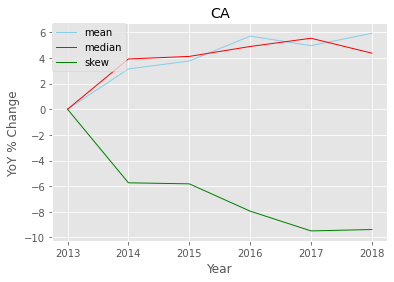

In [25]:
state = 'CA'

plt.plot( 'year', 'mean', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='skyblue', label="mean", linewidth=1)
plt.plot( 'year', 'median', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='red', label="median", linewidth=1)
plt.plot( 'year', 'skew', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='green', label="skew", linewidth=1)

plt.xlabel("Year")
plt.ylabel("YoY % Change")
plt.title(state)

plt.legend(loc='upper left',
           ncol=1, borderaxespad=0.)

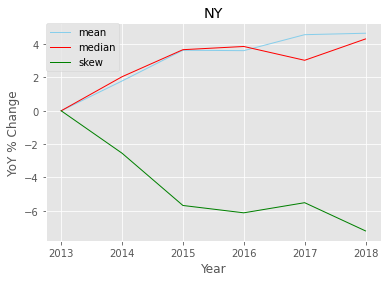

In [26]:
state = 'NY'

plt.plot( 'year', 'mean', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='skyblue', label="mean", linewidth=1)
plt.plot( 'year', 'median', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='red', label="median", linewidth=1)
plt.plot( 'year', 'skew', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='green', label="skew", linewidth=1)

plt.xlabel("Year")
plt.ylabel("YoY % Change")
plt.title(state)

plt.legend(loc='upper left',
           ncol=1, borderaxespad=0.)

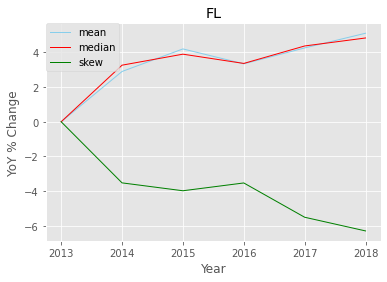

In [28]:
state = 'FL'

plt.plot( 'year', 'mean', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='skyblue', label="mean", linewidth=1)
plt.plot( 'year', 'median', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='red', label="median", linewidth=1)
plt.plot( 'year', 'skew', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='green', label="skew", linewidth=1)

plt.xlabel("Year")
plt.ylabel("YoY % Change")
plt.title(state)

plt.legend(loc='upper left',
           ncol=1, borderaxespad=0.)

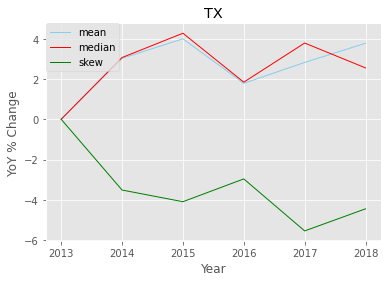

In [29]:
state = 'TX'

plt.plot( 'year', 'mean', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='skyblue', label="mean", linewidth=1)
plt.plot( 'year', 'median', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='red', label="median", linewidth=1)
plt.plot( 'year', 'skew', data=yoy_df_final[yoy_df_final['state']==state], markersize=12, color='green', label="skew", linewidth=1)

plt.xlabel("Year")
plt.ylabel("YoY % Change")
plt.title(state)

plt.legend(loc='upper left',
           ncol=1, borderaxespad=0.)